This notebook visualizes the Phonon Density of States using the best model from extensive experiments conducted for each architecture: MLP, Graph Network, Equivariant Network, MLP with energy embeddings, Graph Network with energy embeddings, and DOSTransformer. Additionally, it displays the RMSE metric evaluated on the test dataset alongside the Phonon DOS.

In [35]:
from pathlib import Path
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from torch_geometric.loader import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
import time
from tqdm import tqdm
from scipy.stats import gaussian_kde
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from ase import Atom, Atoms
# from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
from embedder_phDOS.DOSTransformer_phonon import DOSTransformer_phonon
from embedder_phDOS.graphnetwork_phonon import Graphnetwork_phonon, Graphnetwork2_phonon
from embedder_phDOS.mlp_phonon import mlp_phonon, mlp2_phonon
from embedder_phDOS.e3nn_phonon import e3nn_phonon, get_neighbors

from utils import (
    build_data,
    load_data,
    train_valid_test_split,
    r2, test_phonon1,test_phonon2
)

seed = 0  # this was the default used in the experimentations
random.seed(seed)
np.random.seed(seed)

sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
palette = ['#2876B2', '#F39957', '#67C7C2', '#C86646']
datasets = ['train', 'valid', 'test']
colors = dict(zip(datasets, palette[:-1]))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])
csv_file = Path("data/data.csv")

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
data_df, species = load_data(csv_file)
n_atom_feat = 118
n_bond_feat = 4
n_hidden = 256
out_dim = len(data_df.iloc[0]["phfreq"])


In [36]:
best_models = {
    "mlp" : sorted(Path("experiments/mlp/02/checkpoints").iterdir())[-1],
    "graphnetwork" : sorted(Path("experiments/graphnetwork/05/checkpoints").iterdir())[-1],
    "mlp2" : sorted(Path("experiments/mlp2/02/checkpoints").iterdir())[-1],
    "graphnetwork2" : sorted(Path("experiments/graphnetwork2/04/checkpoints").iterdir())[-1],
    "e3nn" : sorted(Path("experiments/e3nn/04/checkpoints").iterdir())[-1],
    "dostransformer" : sorted(Path("experiments/dostransformer/39/checkpoints").iterdir())[-1]
}

best_models

{'mlp': PosixPath('experiments/mlp/02/checkpoints/epoch_255.pt'),
 'graphnetwork': PosixPath('experiments/graphnetwork/05/checkpoints/epoch_377.pt'),
 'mlp2': PosixPath('experiments/mlp2/02/checkpoints/epoch_255.pt'),
 'graphnetwork2': PosixPath('experiments/graphnetwork2/04/checkpoints/epoch_377.pt'),
 'e3nn': PosixPath('experiments/e3nn/04/checkpoints/epoch_500.pt'),
 'dostransformer': PosixPath('experiments/dostransformer/39/checkpoints/epoch_377.pt')}

In [37]:
def get_neighbors(df, idx):
    """Calculate average number of neighbors."""
    n = []
    for entry in df.iloc[idx].itertuples():
        N = entry.data.pos.shape[0]
        for i in range(N):
            n.append(len((entry.data.edge_index[0] == i).nonzero()))
    return np.array(n)

def rmax_data(df,idx_train, idx_valid, idx_test, r_max):
    """Calculate neighbor statistics for train/val/test split based on cutoff distance."""

    n_train = get_neighbors(df, idx_train)
    n_valid = get_neighbors(df, idx_valid)
    n_test = get_neighbors(df, idx_test)

    return n_train, n_valid, n_test

In [38]:
def plot_predictions(df, idx,modelname, title=None):
    # get quartiles
    i_mse = np.argsort(df.iloc[idx]['mse'])
    ds = df.iloc[idx].iloc[i_mse][['formula', 'phdos', 'phdos_pred', 'mse']].reset_index(drop=True)
    quartiles = np.quantile(ds['mse'].values, (0.25, 0.5, 0.75, 1.))
    iq = [0] + [np.argmin(np.abs(ds['mse'].values - k)) for k in quartiles]

    n = 7
    s = np.concatenate([np.sort(np.random.choice(np.arange(iq[k-1], iq[k], 1), size=n, replace=False)) for k in range(1,5)])
    x = df.iloc[0]['phfreq']

    fig, axs = plt.subplots(4,n+1, figsize=(13,3.5), gridspec_kw={'width_ratios': [0.7] + [1]*n})
    gs = axs[0,0].get_gridspec()

    # remove the underlying axes
    for ax in axs[:,0]:
        ax.remove()

    # add long axis
    axl = fig.add_subplot(gs[:,0])

    # plot quartile distribution
    y_min, y_max = ds['mse'].min(), ds['mse'].max()
    y = np.linspace(y_min, y_max, 500)
    kde = gaussian_kde(ds['mse'])
    p = kde.pdf(y)
    axl.plot(p, y, color='black')
    cols = [palette[k] for k in [2,0,1,3]][::-1]
    qs =  list(quartiles)[::-1] + [0]
    for i in range(len(qs)-1):
        axl.fill_between([p.min(), p.max()], y1=[qs[i], qs[i]], y2=[qs[i+1], qs[i+1]], color=cols[i], lw=0, alpha=0.5)
    axl.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    axl.invert_yaxis()
    axl.set_xticks([])
    axl.set_ylabel('MSE')

    fontsize = 12
    cols = np.repeat(cols[::-1], n)
    axs = axs[:,1:].ravel()
    for k in range(4*n):
        ax = axs[k]
        i = s[k]
        ax.plot(x, ds.iloc[i]['phdos'], color='black')
        ax.plot(x, ds.iloc[i]['phdos_pred'], color=cols[k])
        ax.set_xticks([]); ax.set_yticks([])
        ax.set_title(ds.iloc[i]['formula'].translate(sub), fontsize=fontsize, y=0.95)

    fig.tight_layout()
    fig.subplots_adjust(hspace=0.6)
    if title: fig.suptitle(title, ha='center', y=1., fontsize=fontsize + 4)
    plt.savefig(f"../figures/{modelname}_predictionplots.png", dpi=300)

## DOSTransformer

In [40]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)
model = DOSTransformer_phonon(
            layers = 4,
            t_layers = 4,
            n_atom_feats = n_atom_feat,
            n_bond_feats = n_bond_feat,
            n_hidden = n_hidden,
            device = 0,
            attn_drop = 0.2,
        ).to(device)

r_max = 8

In [41]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["dostransformer"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [42]:
start_time = time.time()
test_stats = test_phonon1(model, test_loader, nn.MSELoss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 302.653594646982


In [43]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output,_,_ = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:04<00:00, 47.69it/s]


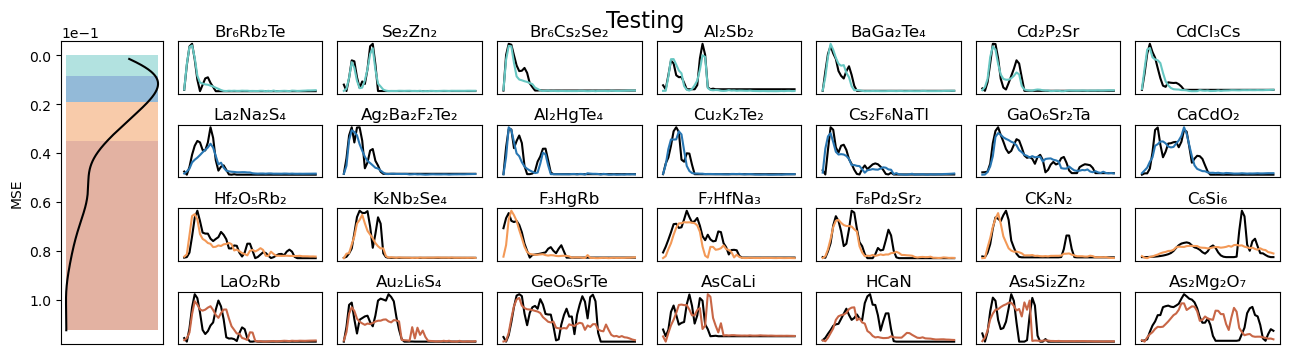

In [44]:
plot_predictions(df, idx_test,'dostransformer', 'Testing')

## E3NN

In [10]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)
model = e3nn_phonon(
            in_dim=118,  # dimension of one-hot encoding of atom type
            em_dim=64,  # dimension of atom-type embedding
            irreps_in=str(64)
            + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
            irreps_out=str(len(df.iloc[0]["phfreq"]))
            + "x0e",  # out_dim scalars (L=0 and even parity) to output
            irreps_node_attr=str(64)
            + "x0e",  # em_dim scalars (L=0 and even parity) on each atom to represent atom type
            layers=4,  # number of nonlinearities (number of convolutions = layers + 1)
            mul=32,  # multiplicity of irreducible representations
            lmax=1,  # maximum order of spherical harmonics
            max_radius=8,  # cutoff radius for convolution
            num_neighbors=get_neighbors(
                df, idx_train
            ).mean(),  # scaling factor based on the typical number of neighbors
            reduce_output=True,  # whether or not to aggregate features of all atoms at the end
        ).to(device)

r_max = 8

In [11]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["e3nn"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [12]:
start_time = time.time()
test_stats = test_phonon2(model, test_loader, nn.MSELoss(),nn.L1Loss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 79.52708160472751


In [13]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:02<00:00, 65.97it/s]


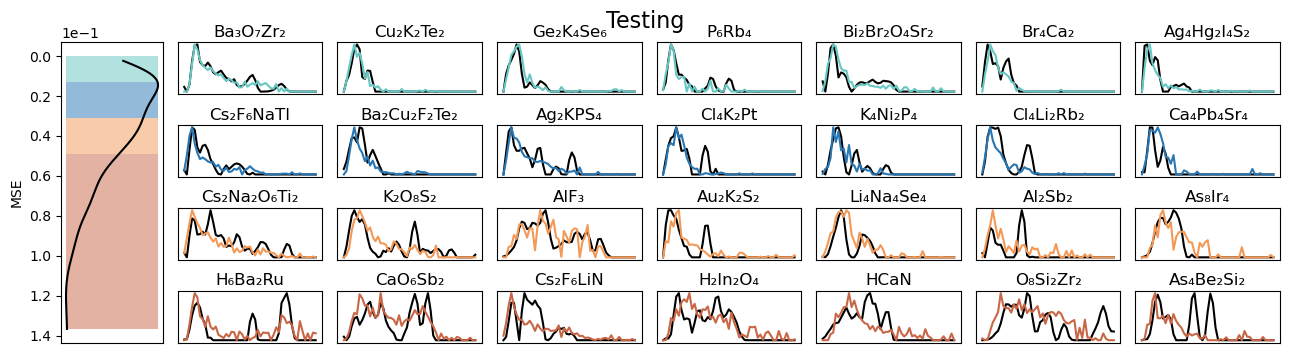

In [14]:
plot_predictions(df, idx_test,'e3nn', 'Testing')

## GNN With Energy Embeddings

In [15]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)
model = Graphnetwork_phonon(
            3, n_atom_feat, n_bond_feat, n_hidden, out_dim, device
        ).to(device)

r_max = 2

In [16]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["graphnetwork"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [17]:
start_time = time.time()
test_stats = test_phonon2(model, test_loader, nn.MSELoss(),nn.L1Loss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 1461.5641403371128


In [18]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:01<00:00, 181.10it/s]


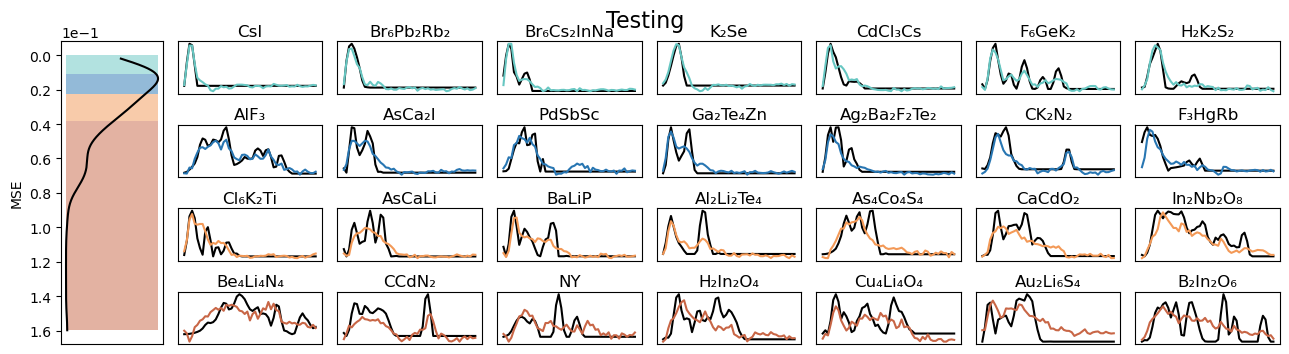

In [19]:
plot_predictions(df, idx_test,'graphnetwork', 'Testing')

## GNN Without Energy Embeddings

In [20]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)

model = Graphnetwork2_phonon(
    4, n_atom_feat, n_bond_feat, n_hidden, out_dim, device
).to(device)

r_max = 8

In [21]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["graphnetwork2"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [22]:
start_time = time.time()
test_stats = test_phonon2(model, test_loader, nn.MSELoss(),nn.L1Loss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 828.8049639641665


In [23]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:01<00:00, 141.47it/s]


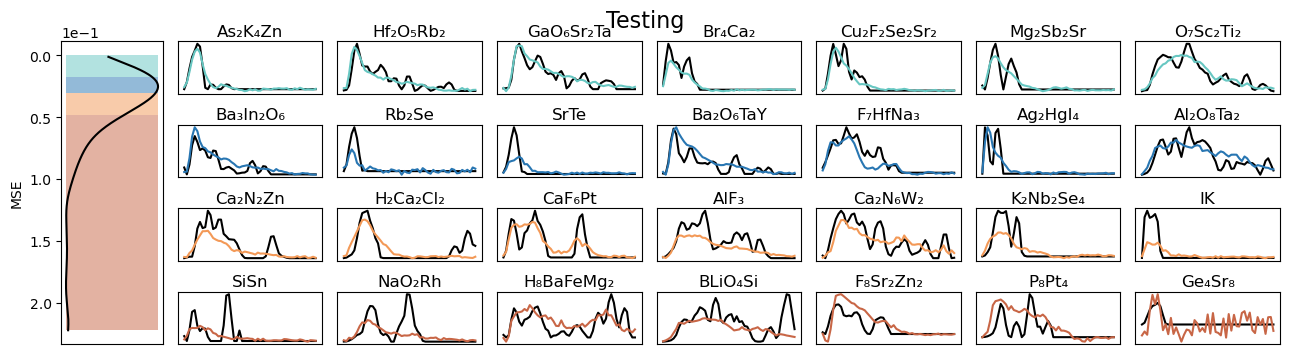

In [24]:
plot_predictions(df, idx_test,'graphnetwork2', 'Testing')

## MLP With Energy Embeddings

In [25]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)

r_max = 4

model = mlp_phonon(
    4, n_atom_feat, n_bond_feat, n_hidden, r_max, device
).to(device)


In [26]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["mlp"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [27]:
start_time = time.time()
test_stats = test_phonon2(model, test_loader, nn.MSELoss(),nn.L1Loss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 1389.2721070085524


In [28]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:00<00:00, 230.02it/s]


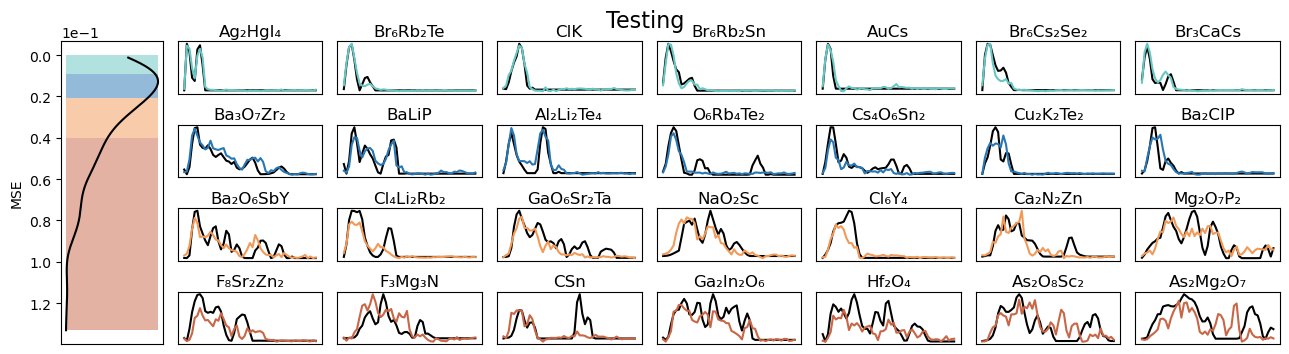

In [29]:
plot_predictions(df, idx_test,'mlp', 'Testing')

## MLP Without Energy Embeddings

In [30]:
device = torch.device(
    f"cuda:0" if torch.cuda.is_available() else "cpu"
)

r_max = 4

model = mlp2_phonon(
            4, n_atom_feat, n_bond_feat, n_hidden,r_max, device
        ).to(device)


In [31]:
csv_file = Path("data/data.csv")
df, species = load_data(csv_file)

df["data"] = df.apply(lambda x: build_data(x, r_max), axis=1)

idx_train, idx_valid, idx_test = train_valid_test_split(
    df, species, valid_size=0.1, test_size=0.1, seed=0
)

train_loader = DataLoader(
    df.iloc[idx_train]["data"].values,
    batch_size=8,
    shuffle=True,
)
valid_loader = DataLoader(
    df.iloc[idx_valid]["data"].values, batch_size=8
)
test_loader = DataLoader(
    df.iloc[idx_test]["data"].values, batch_size=8
)

model.load_state_dict(torch.load(best_models["mlp2"])['state'])
model.pool = True

dataloader = DataLoader(df['data'].values, batch_size=8)

In [32]:
start_time = time.time()
test_stats = test_phonon2(model, test_loader, nn.MSELoss(),nn.L1Loss(), r2, device)
end_time = time.time()
num_samples = len(test_loader.dataset)
throughput = num_samples / (end_time - start_time)
print("Throughput: {}".format(throughput))

Throughput: 1904.9048919251145


In [33]:
df['mse'] = 0.
df['phdos_pred'] = np.empty((len(df), 0)).tolist()

model.to(device)
model.eval()
with torch.no_grad():
    i0 = 0
    for i, d in tqdm(enumerate(dataloader), total=len(dataloader), bar_format=bar_format):
        d.to(device)
        output = model(d)
        loss = F.mse_loss(output, d.phdos, reduction='none').mean(dim=-1).cpu().numpy()
        df.loc[i0:i0 + len(d.phdos) - 1, 'phdos_pred'] = [[k] for k in output.cpu().numpy()]
        df.loc[i0:i0 + len(d.phdos) - 1, 'mse'] = loss
        i0 += len(d.phdos)

df['phdos_pred'] = df['phdos_pred'].map(lambda x: x[0])

100%|██████████| 191/191 [00:00<00:00, 253.24it/s]


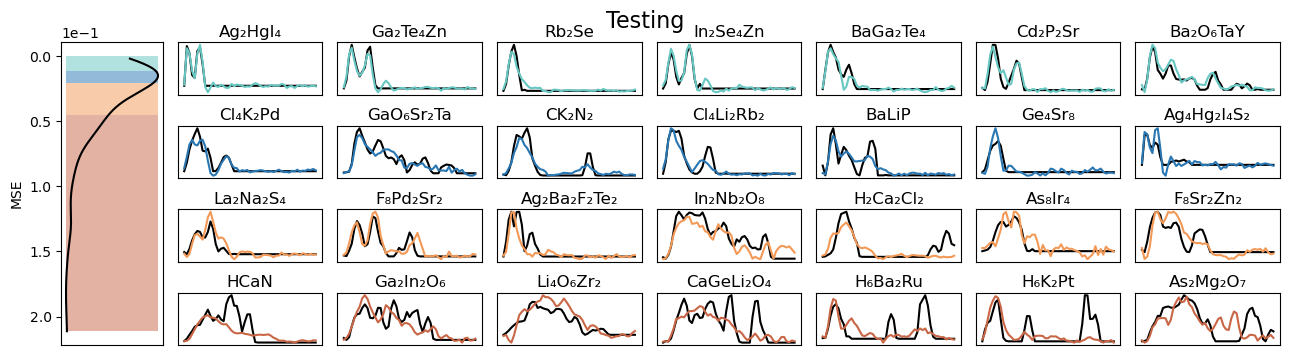

In [34]:
plot_predictions(df, idx_test,'mlp2', 'Testing')